# Latent space models on networks

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import expit
import plotly.express as px
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")

## Network

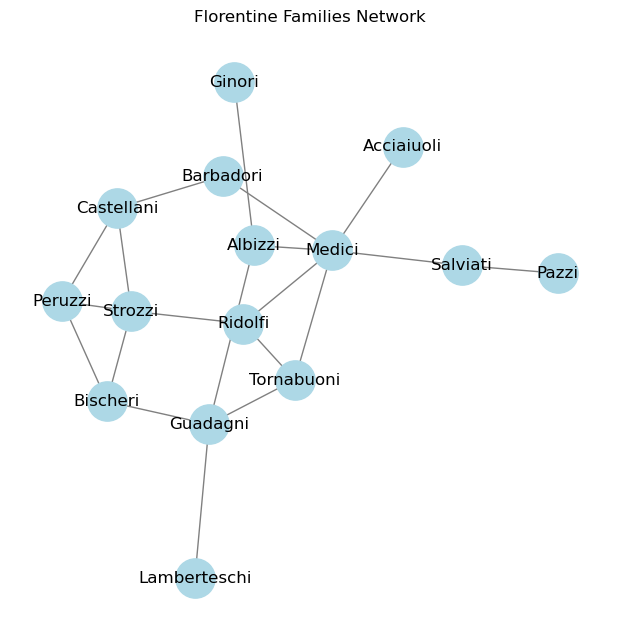

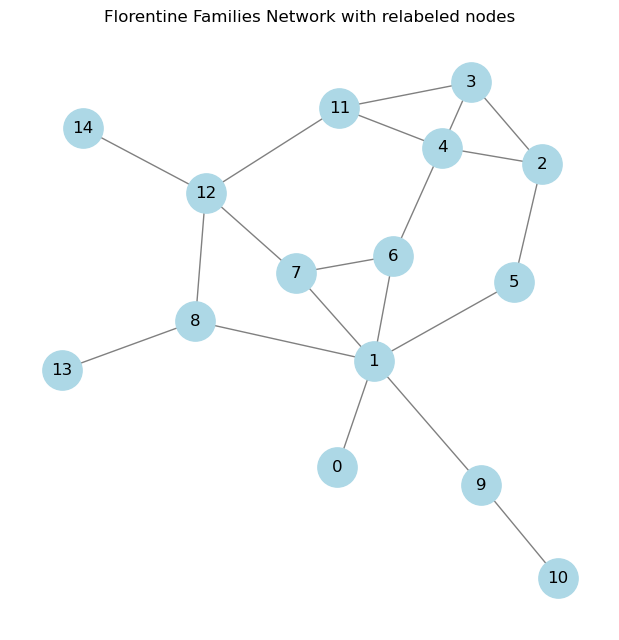

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


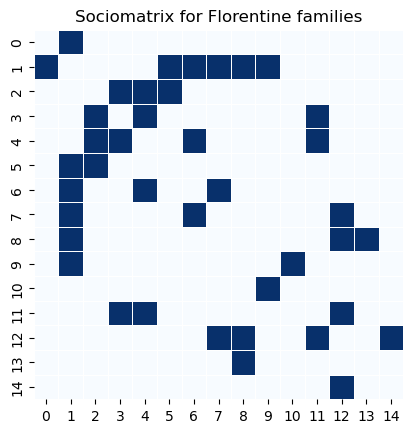

In [3]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show() 

## Initialization and estimation of the model

In [4]:
import numpy as np

def _random_VMF_cos(d, kappa, n):
    """
    Generate n iid samples of cos(theta) from the marginal density:
    p(t) ∝ (1 - t^2)^{(d-2)/2} * exp(kappa * t)
    using the algorithm of Ulrich (1984) / Wood (1994).
    """
    if kappa == 0:
        # Uniform case
        return 2 * np.random.rand(n) - 1
    
    b = (d - 1) / (2 * kappa + np.sqrt(4 * kappa**2 + (d - 1)**2))
    x0 = (1 - b) / (1 + b)
    c = kappa * x0 + (d - 1) * np.log(1 - x0**2)

    samples = []
    while len(samples) < n:
        m = int((n - len(samples)) * 1.5)
        z = np.random.beta((d - 1) / 2, (d - 1) / 2, size=m)
        t = (1 - (1 + b) * z) / (1 - (1 - b) * z)
        u = np.random.uniform(size=m)
        accept = kappa * t + (d - 1) * np.log(1 - x0 * t) - c >= np.log(u)
        samples.extend(t[accept])
    return np.array(samples[:n])


def random_VMF(mu, kappa, size=None):
    """
    Von Mises-Fisher sampler on S^{d-1} in R^d
    Parameters:
        mu: mean direction (array of shape (d,))
        kappa: concentration parameter (float >= 0)
        size: number of samples (int or tuple)
    Returns:
        Samples on the unit sphere in R^d
    """
    mu = np.asarray(mu)
    mu = mu / np.linalg.norm(mu)
    d = mu.shape[0]

    if size is None:
        n = 1
        shape = ()
    else:
        n = np.prod(size)
        shape = size if isinstance(size, tuple) else (size,)

    # Sample cos(theta)
    cos_theta = _random_VMF_cos(d, kappa, n)
    sin_theta = np.sqrt(1 - cos_theta**2)

    # Sample uniformly in the orthogonal complement of mu
    v = np.random.randn(n, d)
    proj = v - (v @ mu)[:, None] * mu
    proj_norm = np.linalg.norm(proj, axis=1, keepdims=True)
    proj_unit = proj / proj_norm

    # Combine to get samples on sphere
    samples = cos_theta[:, None] * mu + sin_theta[:, None] * proj_unit
    return samples.reshape((*shape, d))


In [7]:
def MH_LSMN(Y, Theta, Model):
    print("="*80)
    print(f"Metropolis-Hastings for {Model} latent space models on networks")
    print("="*80)


    n = Y.shape[0]

    Z0 = Theta['Z0']
    alpha0 = Theta['alpha0']
    if Model == "Spherical": beta0 = Theta['beta0']
    sigma_prior_Z = Theta['sigma_prior_Z']
    sigma_prior_alpha = Theta['sigma_prior_alpha']
    if Model == "Spherical": sigma_prior_beta = Theta['sigma_prior_beta']
   
    d = Z0.shape[1]

    n_samples = Theta['n_samples']
    sigma_q_Z = Theta['sigma_q_Z']
    sigma_q_alpha = Theta['sigma_q_alpha']
    if Model == "Spherical": sigma_q_beta = Theta['sigma_q_beta']
    burn_in = Theta['burn_in']
    thin = Theta['thin']
    n_iterations = n_samples * thin + burn_in    

    print(f"MH samples of size {n_samples} with burn-in {burn_in} and thinning {thin}")
    print(f"Number of iterations: {n_iterations}")

    Z_current = Z0.copy()
    alpha_current = alpha0.copy()
    if Model == "Spherical": beta_current = beta0.copy()

    Z_chain = np.zeros((n_iterations, n, d))
    alpha_chain = np.zeros(n_iterations)
    if Model == "Spherical": beta_chain = np.zeros(n_iterations)

    acceptance_rate_trace_Z = np.zeros(n_iterations)
    acceptance_rate_trace_alpha = np.zeros(n_iterations)
    if Model == "Spherical": acceptance_rate_trace_beta = np.zeros(n_iterations)

    log_likelihood_chain = np.zeros(n_iterations)
    log_prior_chain = np.zeros(n_iterations)
    log_posterior_chain = np.zeros(n_iterations)

    accept_count_Z = 0
    total_updates_Z = 0

    accept_count_alpha = 0
    total_updates_alpha = 0

    if Model == "Spherical":
        accept_count_beta = 0
        total_updates_beta = 0

    print(f"Initial sigma_q_Z: {sigma_q_Z:.4f}")
    print(f"Initial sigma_q_alpha: {sigma_q_alpha:.4f}")
    if Model == "Spherical": print(f"Initial sigma_q_beta: {sigma_q_beta:.4f}")


    if Model == "Euclidean":
        def compute_Z_star(Z, Z0):
            """ Computes Z* = Z0 Z^T (Z Z0^T Z0 Z^T)^(-1/2) Z using SVD """
            A = Z @ Z0.T @ Z0 @ Z.T 
            U, S, _ = np.linalg.svd(A)
            S_inv_sqrt = np.diag(1.0 / np.sqrt(S))
            A_inv_sqrt = U @ S_inv_sqrt @ U.T
            Z_star =  Z0 @ Z.T @ A_inv_sqrt @ Z
            # Compute Z*
            return Z_star
    if Model == "Spherical":
        def compute_Z_star(Z, Z0):
            """Orthogonal Procrustes alignment preserving norms"""
            U, _, Vt = np.linalg.svd(Z0.T @ Z)
            R = U @ Vt
            Z_star = Z @ R
            return Z_star

    print("Log-likelihood: Bernoulli")
    def log_likelihood(params):
        total = 0.0
        if Model == "Euclidean":
            Z, alpha = params
            for i in range(n):
                for j in range(i+1,n):
                    dist = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
                    eta = alpha - dist
                    total += eta * Y[i,j] + (-np.logaddexp(0, eta))
        if Model == "Spherical":
            Z, alpha, beta = params
            for i in range(n):
                for j in range(i+1,n):
                    dist = Z[i].T @ Z[j]
                    eta = alpha + beta * dist
                    total += eta * Y[i,j] + (-np.logaddexp(0, eta))
        return total
    
    def grad_loglikelihood(params):
        grad_alpha = 0.0
        grad_beta = 0.0
        if Model == "Euclidean":
            Z, alpha = params
            grad_Z = np.zeros_like(Z)
            for i in range(n):
                for j in range(i+1,n):
                    dist = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
                    eta = alpha - dist
                    grad_Z[i,:] += (-1) * (Z[i] - Z[j]) * (Y[i,j] - expit(eta))
                    grad_alpha +=  (Y[i,j] - expit(eta))
            return grad_Z, grad_alpha
        if Model == "Spherical":
            Z, alpha, beta = params
            grad_Z = np.zeros_like(Z)
            for i in range(n):
                for j in range(i+1,n):
                    dist = Z[i].T @ Z[j] 
                    eta = alpha + beta*dist
                    grad_Z[i,:] +=  (Y[i,j] - expit(eta)) *  (beta * Z[j])
                    grad_alpha += (Y[i,j] - expit(eta)) * (1) 
                    grad_beta += (Y[i,j] - expit(eta)) * (dist) 
            return grad_Z, grad_alpha, grad_beta

    def SearchingMLE(max_iter=200, tol=1e-4, r_init=0.1, rho=0.5, c=1e-4):
        def update_Z(Z, grad_Z):
            for i in range(len(Z)):
                proj_orth = grad_Z[i]-np.dot(Z[i], grad_Z[i]) * Z[i]
                Z[i] = Z[i] + proj_orth 
                Z[i] = Z[i] / np.linalg.norm(Z[i])
            return Z

        Zi = Z0.copy()
        alphai = alpha0.copy()
        historyZ = [Zi]
        historyalpha = [alphai]
        if Model == "Spherical": 
            betai = beta0.copy()
            historybeta = [betai]

        for i in range(max_iter):
            r = r_init
            if Model == "Euclidean":
                grad_Z, grad_alpha = grad_loglikelihood((Zi,alphai))
            while log_likelihood((Zi + r * grad_Z, alphai+r*grad_alpha)) < log_likelihood((Zi,alphai))+ c * r * (np.trace(np.transpose(grad_Z) @ Zi) + grad_alpha * alphai):
                r *= rho
                if r < 1e-9:
                    r = 0.0
                    break
            if Model == "Spherical":
                grad_Z, grad_alpha, grad_beta = grad_loglikelihood((Zi,alphai,betai))
            while  log_likelihood((update_Z(Zi, r*grad_Z) ,alphai+r*grad_alpha,betai+r*grad_beta)) < log_likelihood((Zi,alphai,betai))+ c * r * (np.trace(np.transpose(grad_Z) @ Zi) + grad_alpha * alphai + grad_beta * betai):
                r *= rho
                if r < 1e-9:
                    r = 0.0
                    break
            Zi = Zi + r * grad_Z  
            alphai = alphai + r * grad_alpha
            historyZ.append(Zi)
            historyalpha.append(alphai)
            if Model == "Euclidean":
                if r * np.linalg.norm(grad_Z) < tol and r * np.abs(grad_alpha) < tol:
                    break
            if Model == "Spherical":
                betai = betai + r * grad_beta
                historybeta.append(betai)
                if r * np.linalg.norm(grad_Z) < tol and r * np.abs(grad_alpha) < tol and r * np.abs(grad_beta) < tol:
                    break
        if Model == "Euclidean":  
            return  Zi, alphai
        if Model == "Spherical":
            return  Zi, alphai, betai
            

    if Model == "Euclidean":
        Z_ML, alpha_ML = SearchingMLE()
    if Model == "Spherical":
        Z_ML, alpha_ML, beta_ML = SearchingMLE()   
        
        

    print("Log-prior:")
    print("sigma_prior_Z: ", sigma_prior_Z)
    print("sigma_prior_alpha: ", sigma_prior_alpha)
    if Model == "Spherical": print("sigma_prior_beta: ", sigma_prior_beta)
    
    def log_prior(params):
        total = 0.0
        if Model == "Euclidean":
            Z, alpha = params
            total += - 0.5 * np.sum(Z**2)/sigma_prior_Z**2 
            total += - 0.5 * alpha**2 / sigma_prior_alpha**2
        if Model == "Spherical":
            Z, alpha, beta = params
            for i in range(n):
                total += -0.5 * (Z[i].T @ Z[i] - 1)**2 /sigma_prior_Z**2 
            total += np.log(1/(d*np.pi))
            total += -0.5 * alpha**2 / sigma_prior_alpha**2
            total += -0.5 * beta**2 / sigma_prior_beta**2
        return total
    

    if Model == "Euclidean":
        params_current = (Z_current,alpha_current)
        current_ll = log_likelihood(params_current)
        current_lp = log_prior(params_current)
    if Model == "Spherical":
        params_current = (Z_current,alpha_current,beta_current)
        current_ll = log_likelihood(params_current)
        current_lp = log_prior(params_current)
    current_post = current_ll + current_lp


    

    print("*"*32 + "\nSampling\n" + "*"*32)

    for i in tqdm(range(n_iterations), desc="Sampling progress", unit=" samples"):

        # Z update      
        for l in range(n):
            if Model == "Euclidean":
                Z_proposed = Z_current.copy()
                Z_proposed[l] =  np.random.normal(Z_current[l], sigma_q_Z, d)
                proposed_params = (Z_proposed, alpha_current)
                proposed_ll = log_likelihood(proposed_params)
                proposed_lp = log_prior(proposed_params)
            if Model == "Spherical":
                Z_proposed = Z_current.copy()
                Z_proposed[l] =  random_VMF(Z_current[l], sigma_q_Z, size=1)[0]
                proposed_params = (Z_proposed, alpha_current, beta_current)
                proposed_ll = log_likelihood(proposed_params)
                proposed_lp = log_prior(proposed_params)
            proposed_post = proposed_ll + proposed_lp
            log_r = proposed_post - current_post
            if np.log(np.random.rand()) < log_r:
                Z_current = Z_proposed 
                current_ll = proposed_ll
                current_lp = proposed_lp
                current_post = proposed_post
                accept_count_Z += 1
            total_updates_Z += 1

        Z_chain[i] = compute_Z_star(Z_current, Z_ML)
        acceptance_rate_trace_Z[i] = accept_count_Z / total_updates_Z if total_updates_Z > 0 else 0

        # alpha update
        alpha_proposed =  np.random.normal(alpha_current, sigma_q_alpha)
        if Model == "Euclidean":
                proposed_params = (Z_current, alpha_proposed)
                proposed_ll = log_likelihood(proposed_params)
                proposed_lp = log_prior(proposed_params)
        if Model == "Spherical":
            proposed_params = (Z_current, alpha_proposed, beta_current)
            proposed_ll = log_likelihood(proposed_params)
            proposed_lp = log_prior(proposed_params)
        proposed_post = proposed_ll + proposed_lp
        log_r = proposed_post - current_post
        if np.log(np.random.rand()) < log_r:
            alpha_current = alpha_proposed
            current_ll = proposed_ll
            current_lp = proposed_lp
            current_post = proposed_post
            accept_count_alpha += 1
        total_updates_alpha += 1
        alpha_chain[i] = alpha_current
        acceptance_rate_trace_alpha[i] = accept_count_alpha / total_updates_alpha if total_updates_alpha > 0 else 0


        if Model == "Spherical":
            # beta update
            beta_proposed =  np.random.normal(beta_current, sigma_q_beta)
            proposed_ll = log_likelihood((Z_current, alpha_current, beta_proposed))
            proposed_lp = log_prior((Z_current, alpha_current, beta_proposed))
            proposed_post = proposed_ll + proposed_lp
            log_r = proposed_post - current_post
            if np.log(np.random.rand()) < log_r:
                beta_current = beta_proposed
                current_ll = proposed_ll
                current_lp = proposed_lp
                current_post = proposed_post
                accept_count_beta += 1
            total_updates_beta += 1
            beta_chain[i] = beta_current
            acceptance_rate_trace_beta[i] = accept_count_beta / total_updates_beta if total_updates_beta > 0 else 0



        # Diagnostics update  
        log_likelihood_chain[i] = current_ll
        log_prior_chain[i] = current_lp
        log_posterior_chain[i] = current_post


        # Tunning proposals
        if 0 < i < burn_in:
            if Model == "Euclidean":
                acc_rate_Z = acceptance_rate_trace_Z[i]
                acc_rate_alpha = acceptance_rate_trace_alpha[i]
                factor_Z = 0.995 if acc_rate_Z < 0.6 else 1.005 if acc_rate_Z > 0.8 else 1.0
                sigma_q_Z = np.minimum(np.maximum(sigma_q_Z * factor_Z, 0.001), 3.0)
                factor_alpha = 0.995 if acc_rate_alpha < 0.6 else 1.005 if acc_rate_alpha > 0.8 else 1.0
                sigma_q_alpha = np.minimum(np.maximum(sigma_q_alpha * factor_alpha, 0.001), 3.0)
            if Model == "Spherical":
                acc_rate_Z = acceptance_rate_trace_Z[i]
                acc_rate_alpha = acceptance_rate_trace_alpha[i]
                acc_rate_beta = acceptance_rate_trace_beta[i]
                factor_Z = -0.1 if acc_rate_Z < 0.6 else 0.1 if acc_rate_Z > 0.8 else 0.0
                sigma_q_Z = np.minimum(np.maximum(sigma_q_Z + factor_Z, 5.0), 200.0)
                factor_alpha = 0.995 if acc_rate_alpha < 0.6 else 1.005 if acc_rate_alpha > 0.8 else 1.0
                sigma_q_alpha = np.minimum(np.maximum(sigma_q_alpha * factor_alpha, 0.001), 3.0)
                factor_beta = 0.995 if acc_rate_beta < 0.6 else 1.005 if acc_rate_beta > 0.8 else 1.0
                sigma_q_beta = np.minimum(np.maximum(sigma_q_beta * factor_beta, 0.001), 3.0)
            
        if i == burn_in:
            print("-"*32 + "\nTuning complete\n" + "-"*32)
            print(f"Final sigma_q_Z: {sigma_q_Z:.4f}")
            print(f"Final sigma_q_alpha: {sigma_q_alpha:.4f}")
            if Model == "Spherical": print(f"Final sigma_q_beta: {sigma_q_beta:.4f}")
            Z_dir = Z_chain[i]
    


    # Apply burn-in and thinning
    mask = np.arange(burn_in, n_iterations, thin)
    Z_chain = Z_chain[mask]
    alpha_chain = alpha_chain[mask]
    if Model == "Spherical": beta_chain = beta_chain[mask]
    acceptance_rate_trace_Z = acceptance_rate_trace_Z[mask]
    acceptance_rate_trace_alpha = acceptance_rate_trace_alpha[mask]
    if Model == "Spherical": acceptance_rate_trace_beta = acceptance_rate_trace_beta[mask]
    log_likelihood_chain = log_likelihood_chain[mask]
    log_prior_chain = log_prior_chain[mask]
    log_posterior_chain = log_posterior_chain[mask]

    # Point estimators
    ## Conditional mean
    Z_CM = np.mean(Z_chain, axis=0)
    alpha_CM = np.mean(alpha_chain)
    if Model == "Euclidean":
        cm_log_posterior = log_likelihood((Z_CM,alpha_CM)) + log_prior((Z_CM,alpha_CM))
    if Model == "Spherical":
        for i in range(n):
            Z_CM[i] /= np.linalg.norm(Z_CM[i])
        beta_CM = np.mean(beta_chain)
        cm_log_posterior = log_likelihood((Z_CM,alpha_CM,beta_CM)) + log_prior((Z_CM,alpha_CM,beta_CM))
    ## Maximum a posteriori
    map_index = np.argmax(log_posterior_chain)
    Z_MAP = Z_chain[map_index]
    alpha_MAP = alpha_chain[map_index]
    if Model == "Spherical": beta_MAP = beta_chain[map_index]
    map_log_posterior = log_posterior_chain[map_index]
    
    print("*"*32 + "\nPoint information\n" + "*"*32)
    
    if Model == "Euclidean":
        pointresults = {
        "Initial": {"ll": log_likelihood((Z0,alpha0)), "lp": log_prior((Z0,alpha0))},
        "ML": {"ll": log_likelihood((Z_ML,alpha_ML)), "lp": log_prior((Z_ML,alpha_ML))},
        "CM": {"ll": log_likelihood((Z_CM,alpha_CM)), "lp": log_prior((Z_CM,alpha_CM))},
        "MAP": {"ll": log_likelihood((Z_MAP,alpha_MAP)), "lp": log_prior((Z_MAP,alpha_MAP))}
        }
    if Model == "Spherical":
        pointresults = {
        "Initial": {"ll": log_likelihood((Z0,alpha0,beta0)), "lp": log_prior((Z0,alpha0,beta0))},
        "ML": {"ll": log_likelihood((Z_ML,alpha_ML,beta_ML)), "lp": log_prior((Z_ML,alpha_ML,beta_ML))},
        "CM": {"ll": log_likelihood((Z_CM,alpha_CM,beta_CM)), "lp": log_prior((Z_CM,alpha_CM,beta_CM))},
        "MAP": {"ll": log_likelihood((Z_MAP,alpha_MAP,beta_CM)), "lp": log_prior((Z_MAP,alpha_MAP,beta_MAP))}
        }

    print("-"*60)
    print("{:<10} {:>16} {:>16} {:>16}".format("Point", "Log-likelihood", "Log-prior", "Log-posterior"))
    print("-"*60)

    for key, val in pointresults.items():
        print("{:<10} {:>16.4f} {:>16.4f} {:>16.4f}".format(
            key, val["ll"], val["lp"], val["ll"]+val["lp"]
        ))

    print("-"*60)


    print(f"\nFinal acceptance rate Z: {acceptance_rate_trace_Z[-1]:.4f}")
    print(f"Final acceptance rate alpha: {acceptance_rate_trace_alpha[-1]:.4f}")
    if Model == "Spherical":
        print(f"Final acceptance rate beta: {acceptance_rate_trace_beta[-1]:.4f}")

    print("*"*32)
    print("Execution completed")
    print("*"*32)

    if Model == "Euclidean":
        return {
            'Model': Model,
            'samples': {'Z': Z_chain, "alpha": alpha_chain},
            'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z, "alpha": acceptance_rate_trace_alpha},
            'log_likelihood': log_likelihood_chain,
            'log_prior': log_prior_chain,
            'log_posterior': log_posterior_chain,
            'final_proposal_std': {'Z': sigma_q_Z, "alpha": sigma_q_alpha},
            'cm_estimate': {'Z': Z_CM, "alpha": alpha_CM},
            'map_estimate': {'Z': Z_MAP, "alpha": alpha_MAP},
            'point_estimators_log_posterior': {'CM': cm_log_posterior, "MAP": map_log_posterior},
            'inputs': {'Y': Y, 'Theta': Theta}
        }
    if Model == "Spherical":
        return {
        'Model': Model,
        'samples': {'Z': Z_chain, 'alpha': alpha_chain, 'beta': beta_chain},
        'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z, 'alpha': acceptance_rate_trace_alpha, 'beta': acceptance_rate_trace_beta},
        'log_likelihood': log_likelihood_chain,
        'log_prior': log_prior_chain,
        'log_posterior': log_posterior_chain,
        'final_proposal_std': {'Z': sigma_q_Z, 'alpha': sigma_q_alpha, 'beta': sigma_q_beta},
        'cm_estimate': {'Z': Z_CM, 'alpha': alpha_CM, 'beta': beta_CM},
        'map_estimate': {'Z': Z_MAP, 'alpha': alpha_MAP, 'beta': beta_MAP},
        'point_estimators_log_posterior': {'CM': cm_log_posterior, 'MAP': map_log_posterior},
        'inputs': { 'Y': Y, 'Theta': Theta}
        }


In [8]:
Theta_R = {
    'Z0': np.random.normal(0, 1, size=(15, 3)),
    'alpha0': np.float64(0.0),
    'sigma_prior_Z': 1.0,
    'sigma_prior_alpha': 1.0,
    'n_samples': 2500,      
    'burn_in': 1000,       
    'thin': 5,              
    'sigma_q_Z': 0.2,       
    'sigma_q_alpha': 0.2    
}

Theta_S = {
    'Z0': np.column_stack([np.cos(theta := 2*np.pi*np.random.rand(15)), np.sin(theta)]),
    'alpha0': np.float64(0.0),
    'beta0': np.float64(1.0),
    'sigma_prior_Z': 0.01,
    'sigma_prior_alpha': 1.0,
    'sigma_prior_beta': 1.0,
    'n_samples': 2500,      
    'burn_in': 1000,        
    'thin': 5,              
    'sigma_q_Z': 50.0,       
    'sigma_q_alpha': 0.2,    
    'sigma_q_beta': 0.2      
}

results = MH_LSMN(Y, Theta_S, Model="Euclidean")

Metropolis-Hastings for Euclidean latent space models on networks
MH samples of size 2500 with burn-in 1000 and thinning 5
Number of iterations: 13500
Initial sigma_q_Z: 50.0000
Initial sigma_q_alpha: 0.2000
Log-likelihood: Bernoulli


UnboundLocalError: cannot access local variable 'betai' where it is not associated with a value

## Diagnostic analysis
- Acceptance rate
- Log probabilities traces
- Adjacency matrices of point estimations
- Traces of fixed parameters

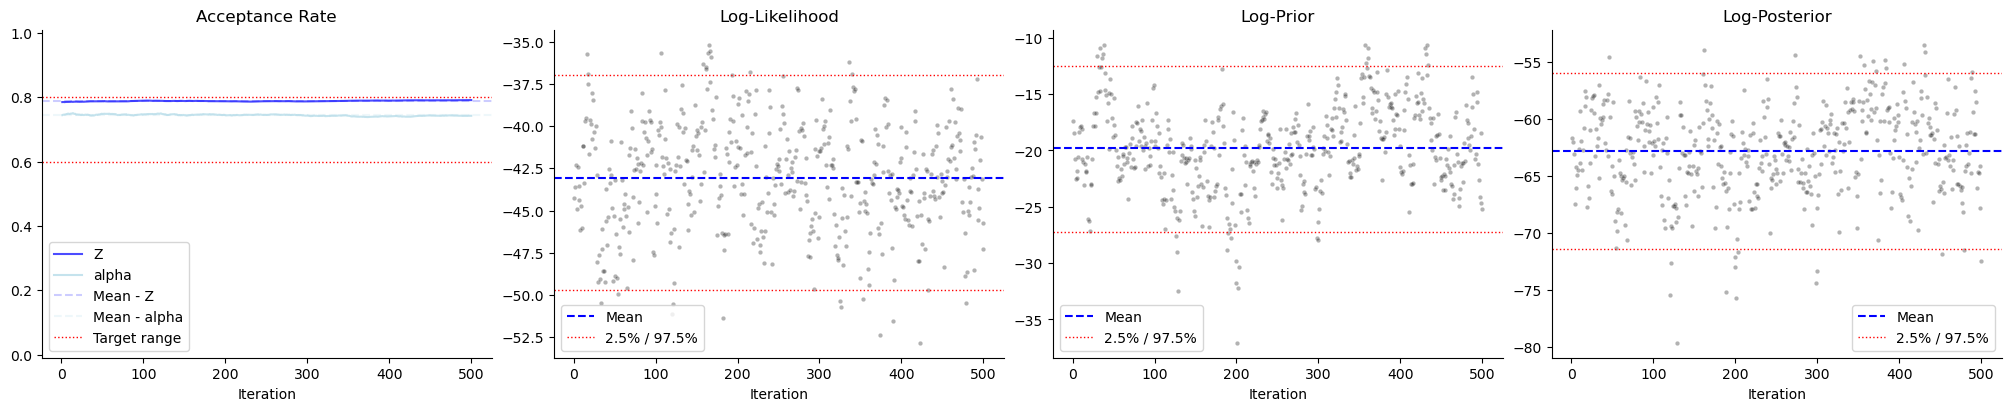

In [ ]:
def plot_mcmc_diagnostics_panel(results):
    """
    Plots a 1x4 panel of MCMC diagnostics: acceptance rate, log-likelihood, log-prior, log-posterior.

    Parameters:
    - results: dict with keys 'acceptance_rate_trace', 'log_likelihood', 'log_prior', 'log_posterior'
    """

    metrics = [
        ("Acceptance Rate", (results['acceptance_rate_trace']['Z'], results['acceptance_rate_trace']['alpha'])),
        ("Log-Likelihood", results['log_likelihood']),
        ("Log-Prior", results['log_prior']),
        ("Log-Posterior", results['log_posterior']),
    ]

    fig, axes = plt.subplots(1, 4, figsize=(20, 4), constrained_layout=True)

    for i, (label, series) in enumerate(metrics):
        if label == "Acceptance Rate":
            iterations = np.arange(1, len(series[0]) + 1)
            sns.lineplot(x=iterations, y=series[0], alpha=0.7, color='blue', ax=axes[i], label='Z')
            sns.lineplot(x=iterations, y=series[1], alpha=0.7, color='lightblue', ax=axes[i], label='alpha')
            axes[i].axhline(np.mean(series[0]), color='blue',alpha=0.2, linestyle='--', label='Mean - Z')
            axes[i].axhline(np.mean(series[1]), color='lightblue',alpha=0.2, linestyle='--', label='Mean - alpha')
            axes[i].axhline(0.6, color='red', linestyle=':', linewidth=1, label='Target range')
            axes[i].axhline(0.8, color='red', linestyle=':', linewidth=1)
            axes[i].set_ylim(-0.01, 1.01)
        else:
            iterations = np.arange(1, len(series) + 1)
            mean_val = np.mean(series)
            sns.scatterplot(x=iterations, y=series, alpha=0.3, color='black', s=10, ax=axes[i])
            axes[i].axhline(mean_val, color='blue', linestyle='--', label='Mean')
            q_025, q_975 = np.quantile(series, [0.025, 0.975])
            axes[i].axhline(q_025, color='red', linestyle=':', linewidth=1, label='2.5% / 97.5%')
            axes[i].axhline(q_975, color='red', linestyle=':', linewidth=1)

        axes[i].set_xlabel("Iteration")
        axes[i].set_title(label)
        axes[i].legend()
        sns.despine(ax=axes[i])

    plt.show()

plot_mcmc_diagnostics_panel(results)

## Visualizing latent space distribution

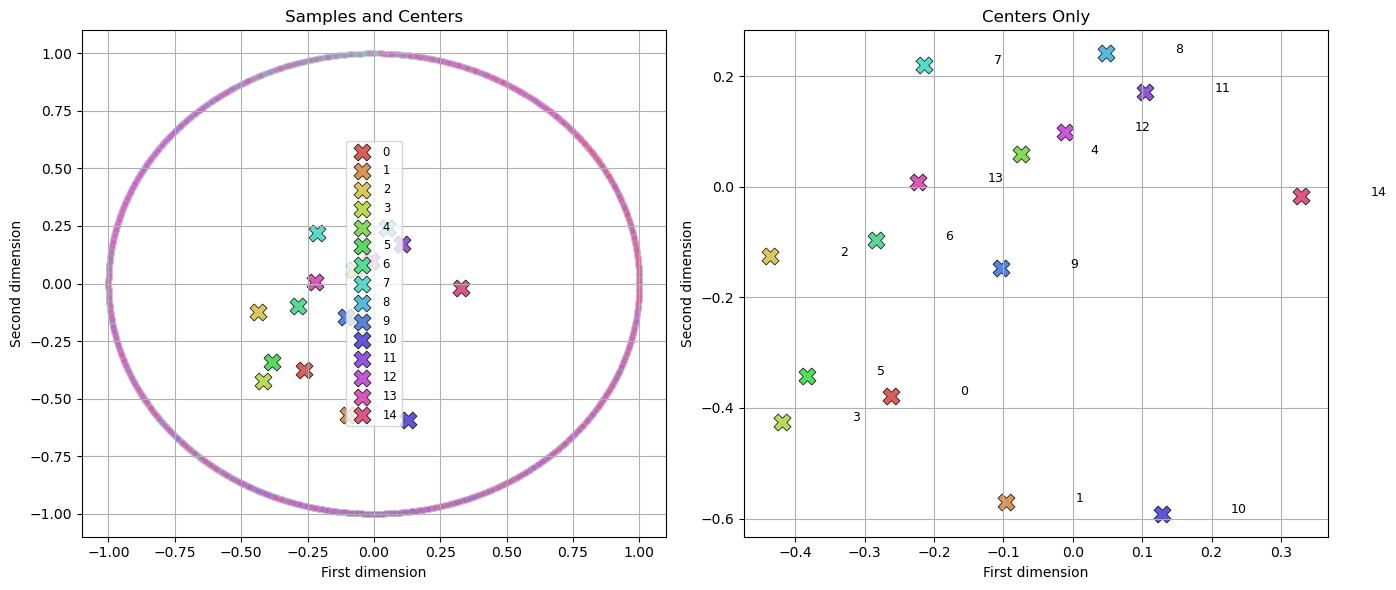

In [8]:
def plot_Z_samples_2D(samples_Z):
    samples_Z = np.array(samples_Z)  
    num_points = samples_Z.shape[1]  
    palette = sns.color_palette("hls", num_points)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    centers = [] 

    for i in range(num_points):
        trace = samples_Z[:, i, :]
        mean_point = trace.mean(axis=0)
        centers.append(mean_point)
        sns.scatterplot(
            ax=axes[0],
            x=trace[:, 0],
            y=trace[:, 1],
            color=palette[i],
            alpha=0.1,
            s=20
        )

        sns.scatterplot(
            ax=axes[0],
            x=[mean_point[0]],
            y=[mean_point[1]],
            color=palette[i],
            marker='X',
            s=150,
            edgecolor='black',
            linewidth=0.5,
            label=f"{i}"
        )

        axes[1].scatter(
            mean_point[0],
            mean_point[1],
            color=palette[i],
            s=150,
            marker='X',
            edgecolor='black',
            linewidth=0.5
        )
        axes[1].text(
            mean_point[0] + 0.1,
            mean_point[1] + 0.001,
            f"{i}",
            fontsize=9
        )

    axes[0].set_title("Samples and Centers")
    axes[0].set_xlabel("First dimension")
    axes[0].set_ylabel("Second dimension")
    axes[0].legend(loc="best", fontsize="small")
    axes[0].grid(True)

    axes[1].set_title("Centers Only")
    axes[1].set_xlabel("First dimension")
    axes[1].set_ylabel("Second dimension")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
plot_Z_samples_2D(results['samples']['Z'])


In [13]:
theta_samples = np.arctan2(results['samples']['Z'][:, :, 1], results['samples']['Z'][:, :, 0]) + np.pi

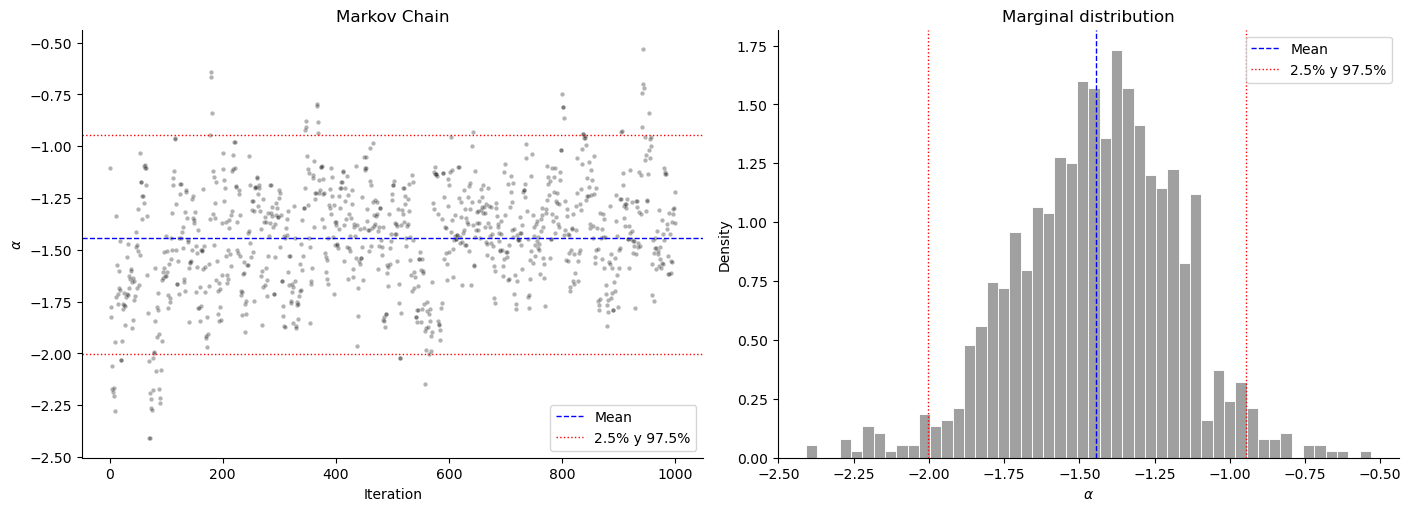

In [9]:
def plot_alpha(x):
    iterations = np.arange(1, len(x) + 1)

    mean_x = np.mean(x)
    quantiles_x = np.quantile(x, [0.025, 0.975])

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
    axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel(r"$\alpha$")
    axes[0].set_title("Markov Chain")
    axes[0].legend()
    sns.despine(ax=axes[0])

    sns.histplot(x, bins=50, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
    axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
    axes[1].set_xlabel(r"$\alpha$")
    axes[1].set_ylabel("Density")
    axes[1].set_title("Marginal distribution")
    axes[1].legend()
    sns.despine(ax=axes[1])

    plt.show()

plot_alpha(results['samples']['alpha'])

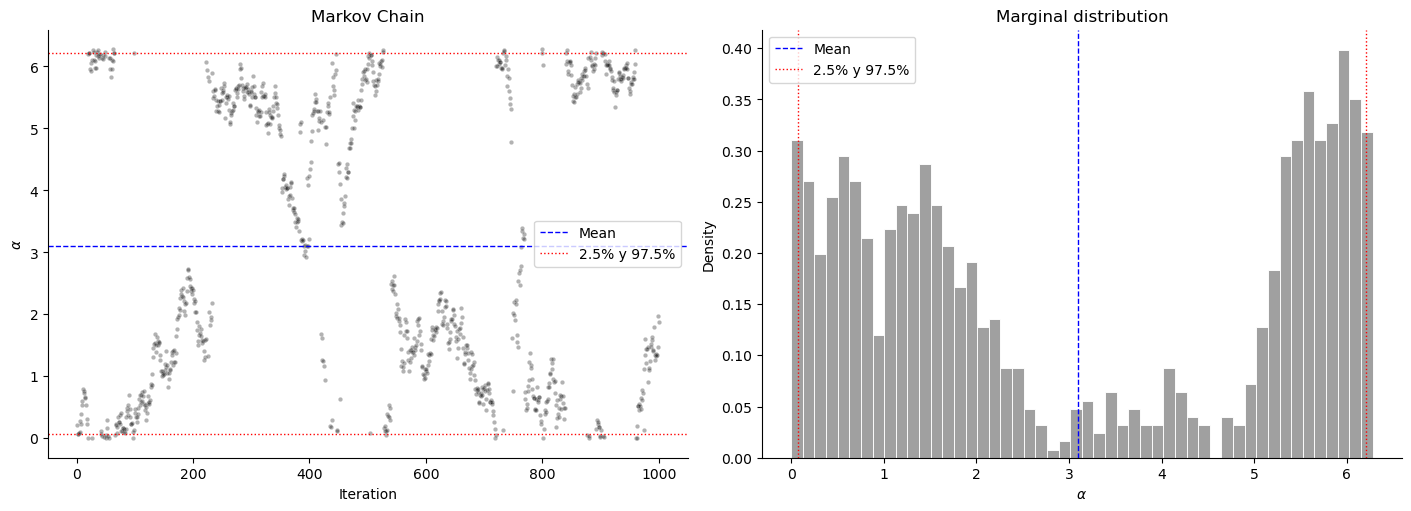

In [16]:
plot_alpha(theta_samples[:,2])